# Visualize the PR curves and probability distribution for control cells to evaluate performance

## Import libraries

In [1]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(tidyr)
    library(dplyr)
    library(arrow)
    library(ggridges)
    library(RColorBrewer)
})

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘arrow’ was built under R version 4.2.3”
Warning message:
“package ‘ggridges’ was built under R version 4.2.3”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.3”


## Set output figure directory

In [2]:
output_dir <- "figures"
if (!dir.exists(output_dir)) {
    dir.create(output_dir, recursive = TRUE)
}

## Read in the performance metrics

In [3]:
performance_metrics <- read_parquet("./performance_metrics/performance_metrics.parquet")

head(performance_metrics)

model_type,dataset,plate_trained,actual_label,predicted_probability,precision,recall,Metadata_treatment
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
final,train,localhost240927120001,failing,0.08024282,0.5000000,1,DMSO
final,train,localhost240927120001,failing,0.02866418,0.5009346,1,DMSO
final,train,localhost240927120001,failing,0.04418054,0.5018727,1,DMSO
final,train,localhost240927120001,failing,0.19241037,0.5028143,1,DMSO
final,train,localhost240927120001,failing,0.07921747,0.5037594,1,DMSO
final,train,localhost240927120001,failing,0.03008184,0.5047081,1,DMSO


## Create a mapping for the plate names for better readability and apply to metrics

In [4]:
# Create a mapping for localhost names
localhost_names <- setdiff(unique(performance_metrics$plate_trained), "combined_batch1")
plate_mapping <- setNames(paste0("plate", seq_along(localhost_names)), localhost_names)
plate_mapping["combined_batch1"] <- "combined_batch1" # keep the original name for combined_batch1

# Apply the mapping to the performance_metrics dataframe
performance_metrics$plate_trained <- plate_mapping[performance_metrics$plate_trained]

# Convert named vector to a data frame
plate_mapping_df <- data.frame(
  original = names(plate_mapping),
  mapped = unname(plate_mapping)
)

# Save as CSV
write.csv(plate_mapping_df, "batch1_plate_name_mapping.csv", row.names = FALSE)

# Display the mapping
print(plate_mapping)
head(performance_metrics)

localhost240927120001 localhost240928120001 localhost240927060001 
             "plate1"              "plate2"              "plate3" 
localhost240926150001       combined_batch1 
             "plate4"     "combined_batch1" 


model_type,dataset,plate_trained,actual_label,predicted_probability,precision,recall,Metadata_treatment
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
final,train,plate1,failing,0.08024282,0.5000000,1,DMSO
final,train,plate1,failing,0.02866418,0.5009346,1,DMSO
final,train,plate1,failing,0.04418054,0.5018727,1,DMSO
final,train,plate1,failing,0.19241037,0.5028143,1,DMSO
final,train,plate1,failing,0.07921747,0.5037594,1,DMSO
final,train,plate1,failing,0.03008184,0.5047081,1,DMSO


In [5]:
# Copy original dataset values
dataset_original <- performance_metrics$dataset

# Extract base name from 'test_localhostX' or 'holdout_localhostY'
base_names <- sub("^(test_|holdout_)", "", dataset_original)

# Map base names if they exist in plate_mapping, otherwise keep original
mapped_base <- ifelse(base_names %in% names(plate_mapping),
                      plate_mapping[base_names],
                      base_names)

# Reattach prefixes (test_/holdout_/none)
performance_metrics$dataset <- ifelse(
  grepl("^test_", dataset_original),
  paste0("test_", mapped_base),
  ifelse(
    grepl("^holdout_", dataset_original),
    paste0("holdout_", mapped_base),
    mapped_base
  )
)

# Display the updated dataframe and check that the mapping worked
unique(performance_metrics$dataset)
head(performance_metrics)

[1] "train"          "test"           "holdout_plate2" "holdout_plate3"
 [5] "holdout_plate4" "holdout_plate1" "test_plate4"    "test_plate3"   
 [9] "test_plate1"    "test_plate2"

model_type,dataset,plate_trained,actual_label,predicted_probability,precision,recall,Metadata_treatment
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
final,train,plate1,failing,0.08024282,0.5000000,1,DMSO
final,train,plate1,failing,0.02866418,0.5009346,1,DMSO
final,train,plate1,failing,0.04418054,0.5018727,1,DMSO
final,train,plate1,failing,0.19241037,0.5028143,1,DMSO
final,train,plate1,failing,0.07921747,0.5037594,1,DMSO
final,train,plate1,failing,0.03008184,0.5047081,1,DMSO


## Generate PR curves with the testing and training data per trained plate model

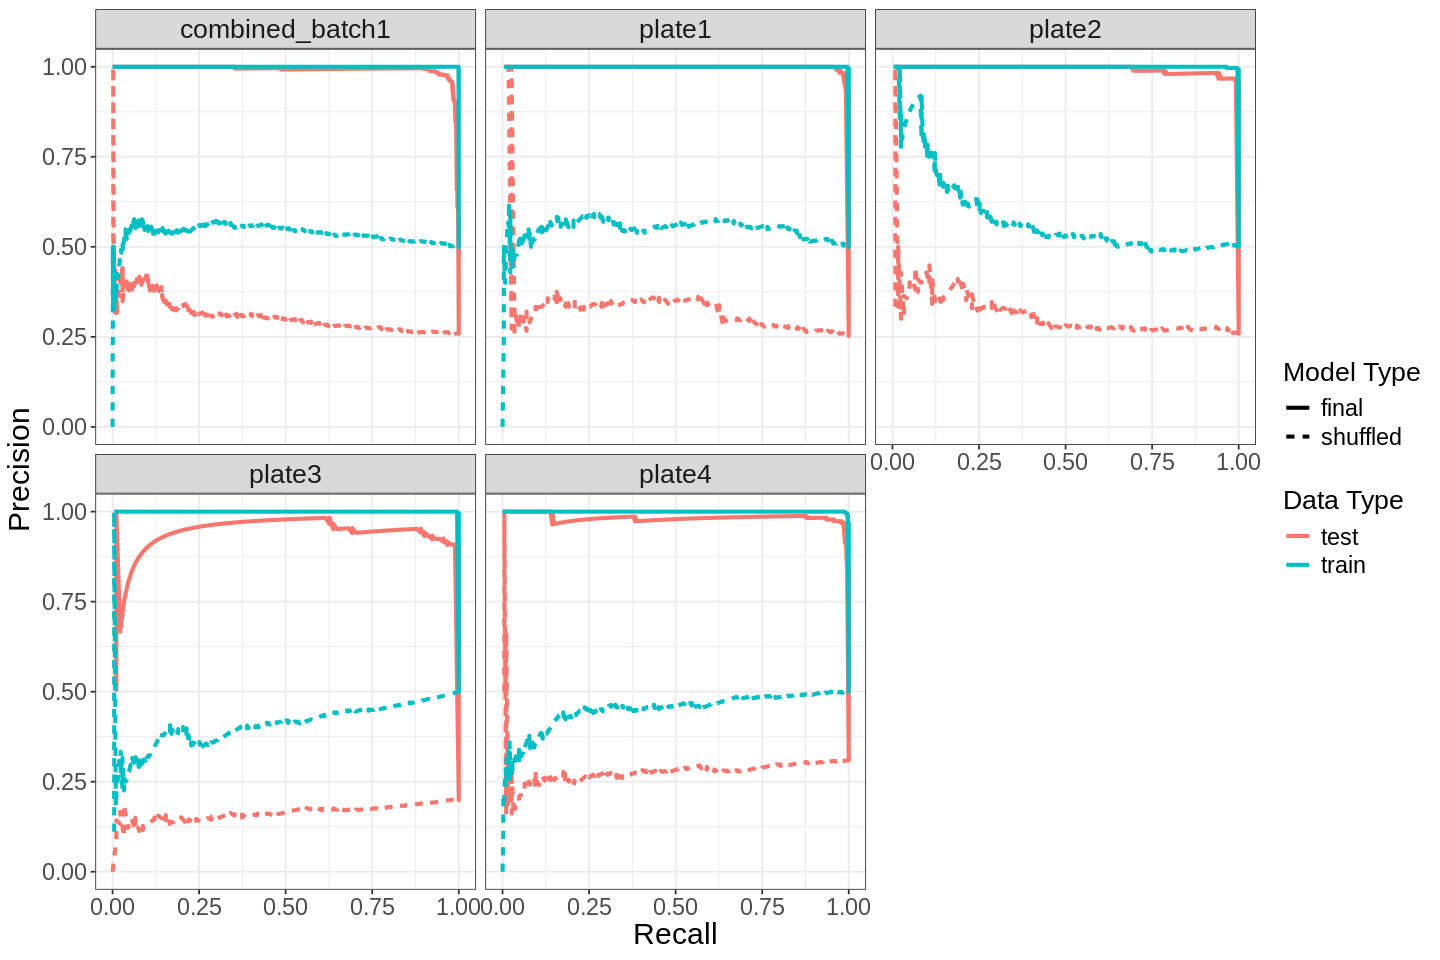

In [6]:
width = 12
height = 8
options(repr.plot.width = 12, repr.plot.height = 8)  # Adjust width and height as desired

# Filter the data for Train and Test only
filtered_data <- performance_metrics[performance_metrics$dataset %in% c("train", "test"), ]

# Create the ggplot for PR curves
test_train_all_models <- ggplot(filtered_data, aes(x = recall, y = precision, color = dataset, linetype = model_type)) +
    geom_line(linewidth = 1.15) +
    facet_wrap(plate_trained ~ .) +
    labs(
        x = "Recall",
        y = "Precision",
        color = "Data Type",
        linetype = "Model Type"
    ) +
    theme_bw() +
    theme(
        text = element_text(size = 16),  # Increase font size for all text
        axis.title = element_text(size = 18),  # Increase font size for axis titles
        axis.text = element_text(size = 14),  # Increase font size for axis text
        legend.title = element_text(size = 16),  # Increase font size for legend title
        legend.text = element_text(size = 14),  # Increase font size for legend text
        strip.text = element_text(size = 16)  # Increase font size for facet labels
    )

# Save the plot to the output directory
ggsave(file.path(output_dir, "test_train_all_models_pr_curves.png"), test_train_all_models, dpi = 500, height = height, width = width)

test_train_all_models

## Generate PR curves with the holdout plates per trained plate model (excludes the combined batch model)

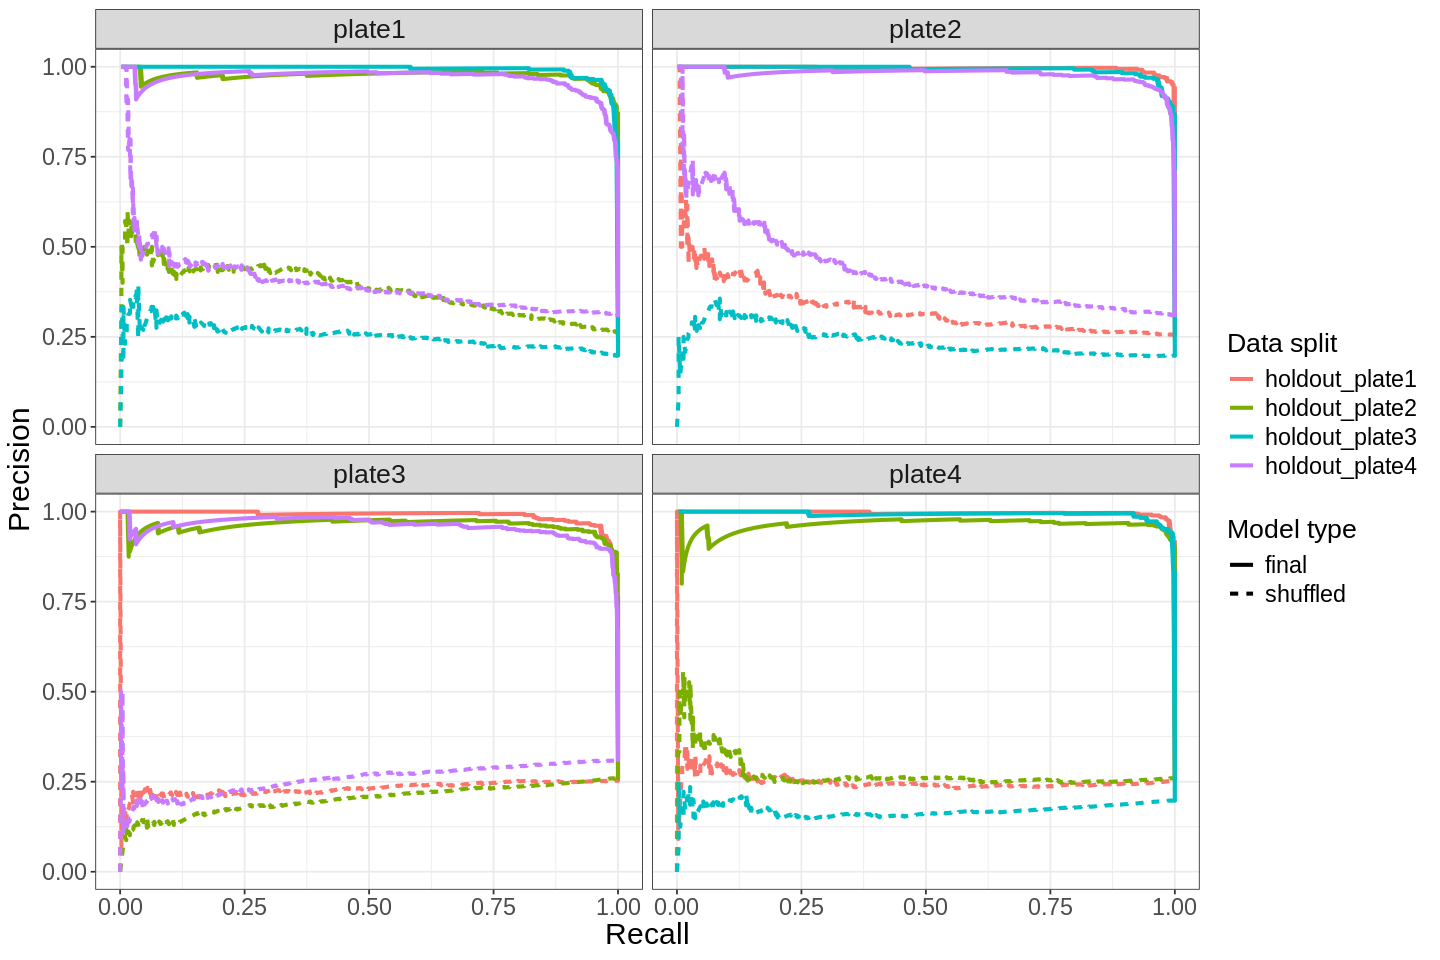

In [7]:
width = 10
height = 8
options(repr.plot.width = 12, repr.plot.height = 8)  # Adjust width and height as desired

# Filter out everything that is not Train and Test, and exclude those with 'test_' as a prefix
filtered_data <- performance_metrics[!(performance_metrics$dataset %in% c("train", "test") | grepl("^test_", performance_metrics$dataset)), ]

# Create the ggplot for PR curves with larger font sizes
holdout_pr_curves <- ggplot(filtered_data, aes(x = recall, y = precision, color = dataset, linetype = model_type)) +
    geom_line(linewidth = 1.15) +
    facet_wrap(plate_trained ~ .) +
    labs(
        x = "Recall",
        y = "Precision",
        color = "Data split",
        linetype = "Model type"
    ) +
    theme_bw() +
    theme(
        text = element_text(size = 16),  # Increase font size for all text
        axis.title = element_text(size = 18),  # Increase font size for axis titles
        axis.text = element_text(size = 14),  # Increase font size for axis text
        legend.title = element_text(size = 16),  # Increase font size for legend title
        legend.text = element_text(size = 14),  # Increase font size for legend text
        strip.text = element_text(size = 16)  # Increase font size for facet labels
    )

# Save the plot to the output directory
ggsave(file.path(output_dir, "holdout_plate_pr_curves.png"), holdout_pr_curves, dpi = 500, height = height, width = width)

holdout_pr_curves

## Generate PR curves with the holdout data for the combined batch model (the holdout data is the testing dataset split by plate)

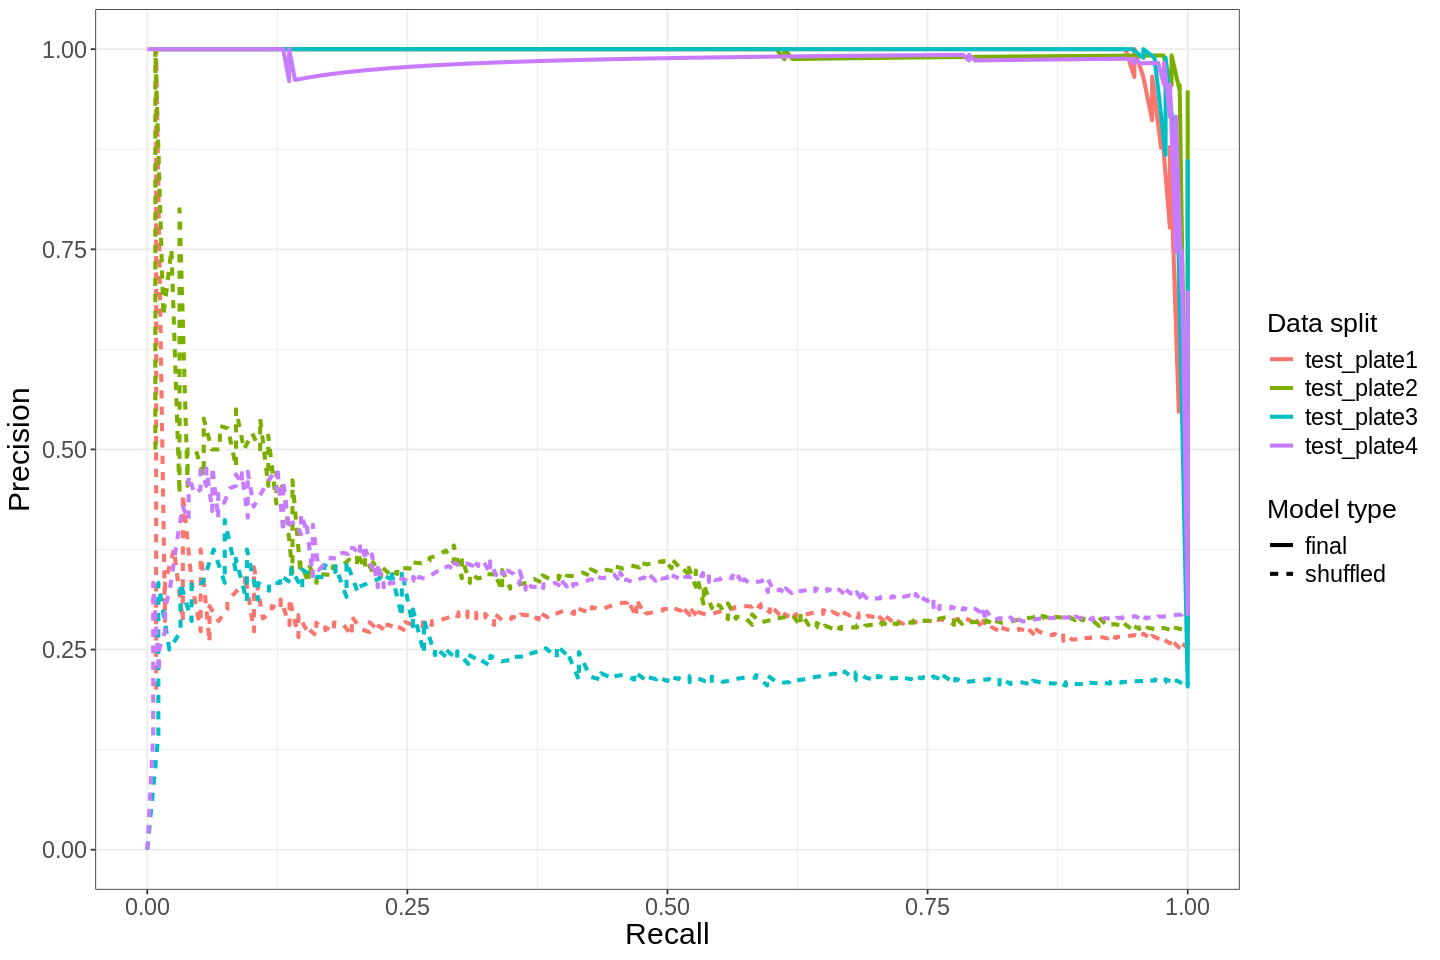

In [8]:
width = 8
height = 6
options(repr.plot.width = 12, repr.plot.height = 8)  # Adjust width and height as desired

# Filter to only keep rows with 'test_' as a prefix in the dataset column
filtered_data <- performance_metrics[grepl("^test_", performance_metrics$dataset), ]

# Create the ggplot for PR curves with larger font sizes
holdout_combined_model_curves <- ggplot(filtered_data, aes(x = recall, y = precision, color = dataset, linetype = model_type)) +
    geom_line(linewidth = 1.15) +
    labs(
        x = "Recall",
        y = "Precision",
        color = "Data split",
        linetype = "Model type"
    ) +
    theme_bw() +
    theme(
        text = element_text(size = 16),  # Increase font size for all text
        axis.title = element_text(size = 18),  # Increase font size for axis titles
        axis.text = element_text(size = 14),  # Increase font size for axis text
        legend.title = element_text(size = 16),  # Increase font size for legend title
        legend.text = element_text(size = 14),  # Increase font size for legend text
        strip.text = element_text(size = 16)  # Increase font size for facet labels
    )

# Save the plot to the output directory
ggsave(file.path(output_dir, "holdout_combined_model_pr_curves.png"), holdout_combined_model_curves, dpi = 500, height = height, width = width)

holdout_combined_model_curves

## Generate a ridge plot per trained plate model with only the testing data to see if the probability distributions for the DMSO controls look correct

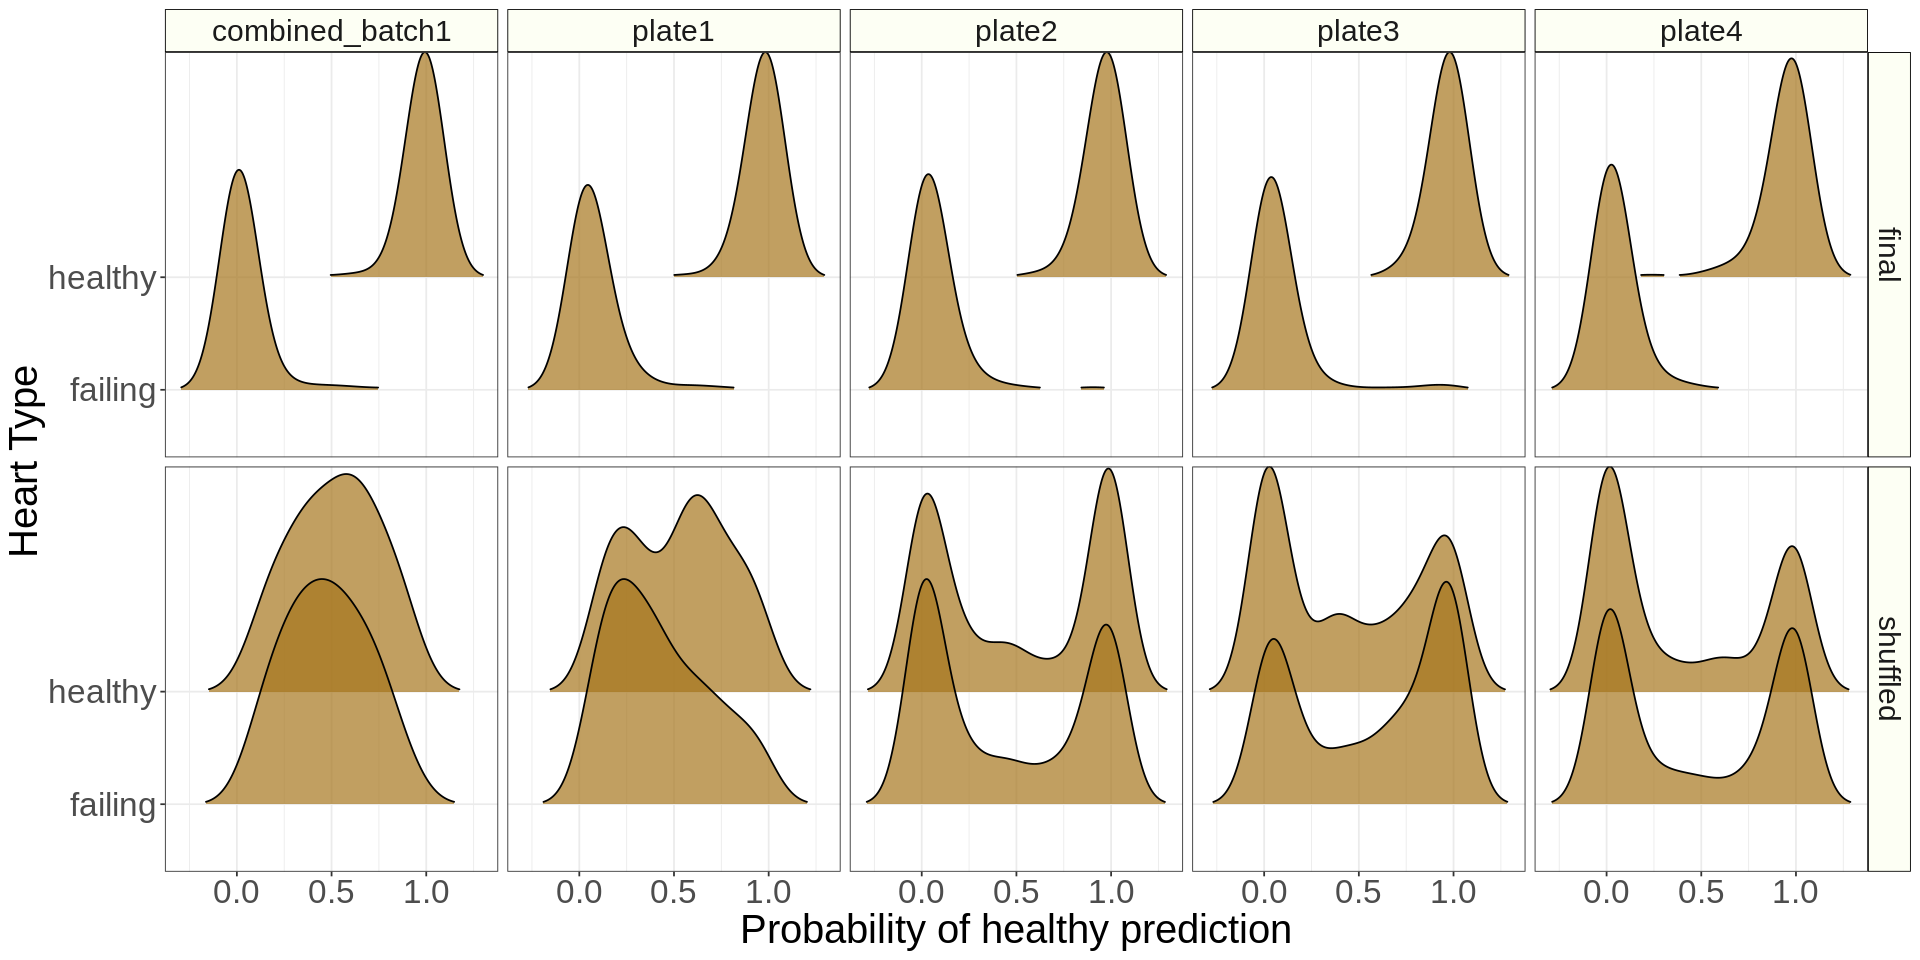

In [9]:
# Filter to only include DMSO treatment
DMSO_performance_df <- performance_metrics %>% filter(Metadata_treatment == "DMSO")

# Filter the data for Train and Test only
DMSO_performance_df <- DMSO_performance_df[DMSO_performance_df$dataset %in% c("test"), ]

height <- 8
width <- 16
options(repr.plot.width = width, repr.plot.height = height)

ridge_plot_controls <- ggplot(DMSO_performance_df, aes(x = predicted_probability, y = actual_label, fill = Metadata_treatment)) +
  geom_density_ridges(aes(fill = Metadata_treatment), alpha = 0.7, scale = 2, rel_min_height = 0.01, bandwidth = 0.1) +
  scale_fill_manual(values = c("DMSO" = brewer.pal(8, "Dark2")[7])) +  # Only include DMSO color
  scale_x_continuous(breaks = seq(0, 1, 0.5)) +
  facet_grid(model_type ~ plate_trained, scales = "free_y") + 
  labs(x = "Probability of healthy prediction", y = "Heart Type") +  # Update x-axis label
  theme_bw() +
  theme(
    legend.position = "none",
    axis.text = element_text(size = 20),
    axis.text.x = element_text(size = 20),
    axis.title = element_text(size = 24),
    strip.text = element_text(size = 18),
    strip.background = element_rect(
      colour = "black",
      fill = "#fdfff4"
    )
  )

# Save the plot to the output directory
ggsave(file.path(output_dir, "DMSO_controls_prob_ridge_plot_testing_data.png"), ridge_plot_controls, dpi = 500, height = height, width = width)

ridge_plot_controls